In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import GARCH, ARCH, Naive, AutoARIMA
from datasetsforecast.losses import mae
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  10221.099609  115.116295  6.079517  10221.099609  156.500961   
2018-02-01  10397.900391  109.582001  5.985532  10397.900391  148.977051   
2018-03-01   6973.529785  108.956589  5.731614   6973.529785  146.682602   
2018-04-01   9240.549805  102.941696  5.566043   9240.549805  138.585083   
2018-05-01   7494.169922  100.349686  6.241442   7494.169922  135.095596   

Price                        High                               Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA      BTC-USD   
Date                                                                  
2018-01-01  6.14500  17712.400391  163.604202  6.23175  9402.290039   
2018-02-01  6.05000  11958.500000  156.912048  6.29925  6048.259766   
2018-03-01  5.78975  11704.099609  154.980881  6.36250  6683.930176   
2018-04-01  5.62250   9745.320312  154.875717  5.98125  6526.870117   
2018-05-01  6.30475   9964.500000  139.770554  6.51250  7090.680176   

Price                                   Open                       \
Ticker             IBM    NVDA       BTC-USD         IBM     NVDA   
Date                                                                
2018-01-01  146.787766  4.8625  14112.200195  147.705551  4.89450   
2018-02-01  138.049713  5.1000  10237.299805  156.013382  5.96300   
2018-03-01  142.007645  5.4250  10385.000000  148.690247  6.04775   
2018-04-01  137.772461  5.2575   7003.060059  146.596558  5.71850   
2018-05-01  133.747604  5.5550   9251.469727  138.288712  5.61425   

Price             Volume                          
Ticker           BTC-USD        IBM         NVDA  
Date                                              
2018-01-01  416247858176  151760375  11456216000  
2018-02-01  229717780480  107073687  14915528000  
2018-03-01  193751709184   98655478  14118440000  
2018-04-01  196550010624  128391583  11144008000  
2018-05-01  197611709696   92898293  11978240000

In [4]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,10221.099609,6.079517,115.116295
1,2018-02-01,10397.900391,5.985532,109.582001
2,2018-03-01,6973.529785,5.731614,108.956589
3,2018-04-01,9240.549805,5.566043,102.941696
4,2018-05-01,7494.169922,6.241442,100.349686


In [5]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices


,unique_id,ds,y
0,BTC-USD,2018-01-01,10221.099609
1,BTC-USD,2018-02-01,10397.900391
2,BTC-USD,2018-03-01,6973.529785
3,BTC-USD,2018-04-01,9240.549805
4,BTC-USD,2018-05-01,7494.169922
...,...,...,...
175,IBM,2022-08-01,117.183632
176,IBM,2022-09-01,109.754768
177,IBM,2022-10-01,127.750092
178,IBM,2022-11-01,137.551437


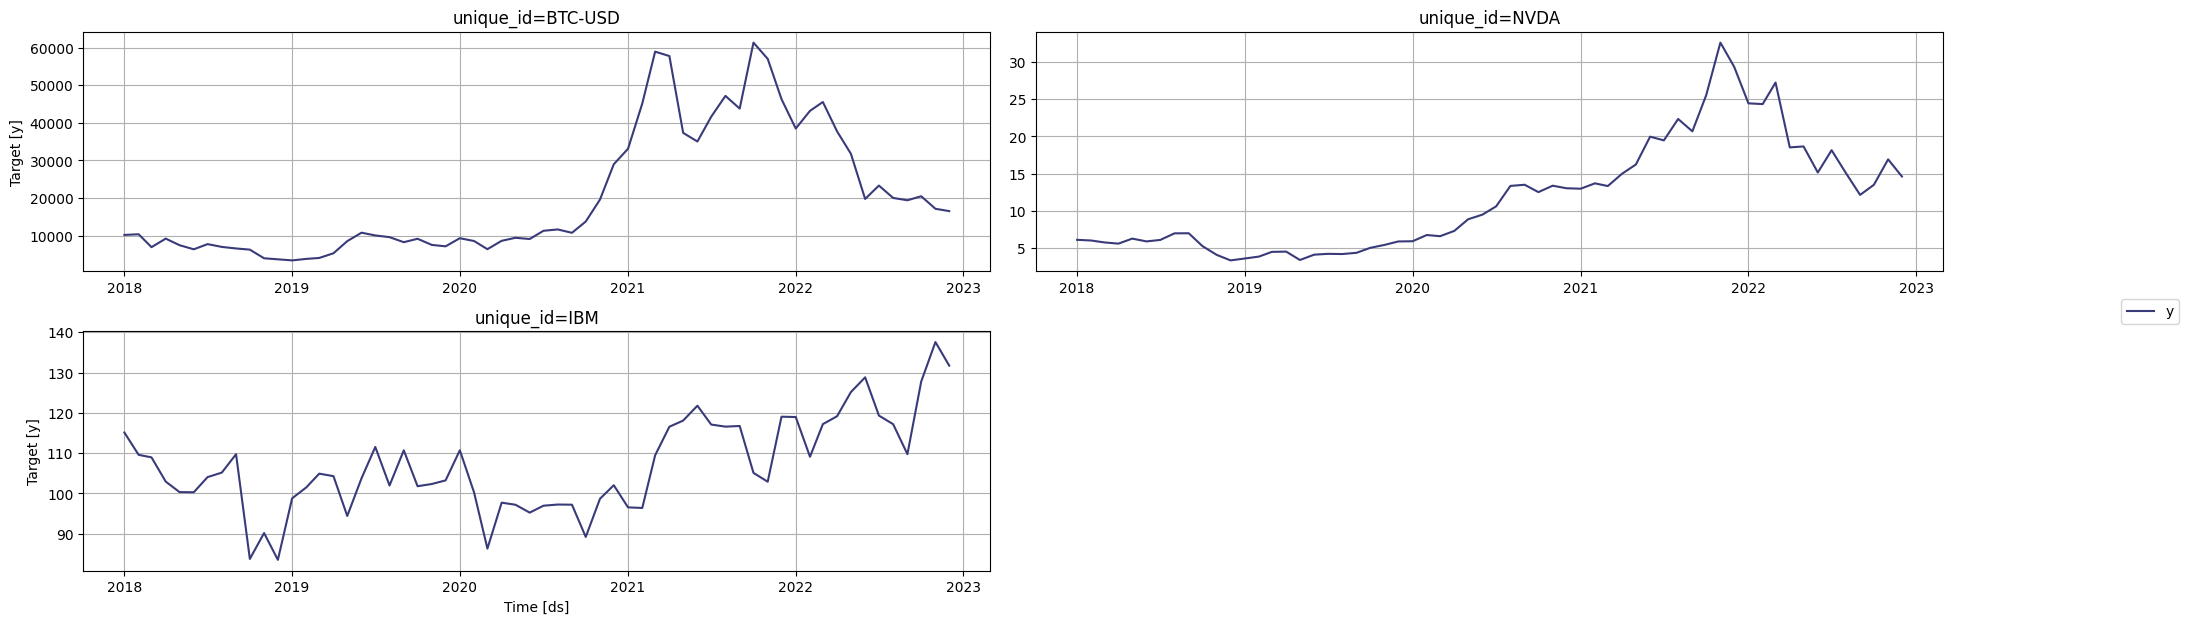

In [6]:
StatsForecast.plot(prices)

In [7]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns


,unique_id,ds,y
0,BTC-USD,2018-01-01,NaN
1,BTC-USD,2018-02-01,0.017150
2,BTC-USD,2018-03-01,-0.399482
3,BTC-USD,2018-04-01,0.281480
4,BTC-USD,2018-05-01,-0.209476
...,...,...,...
175,IBM,2022-08-01,-0.018053
176,IBM,2022-09-01,-0.065494
177,IBM,2022-10-01,0.151827
178,IBM,2022-11-01,0.073922


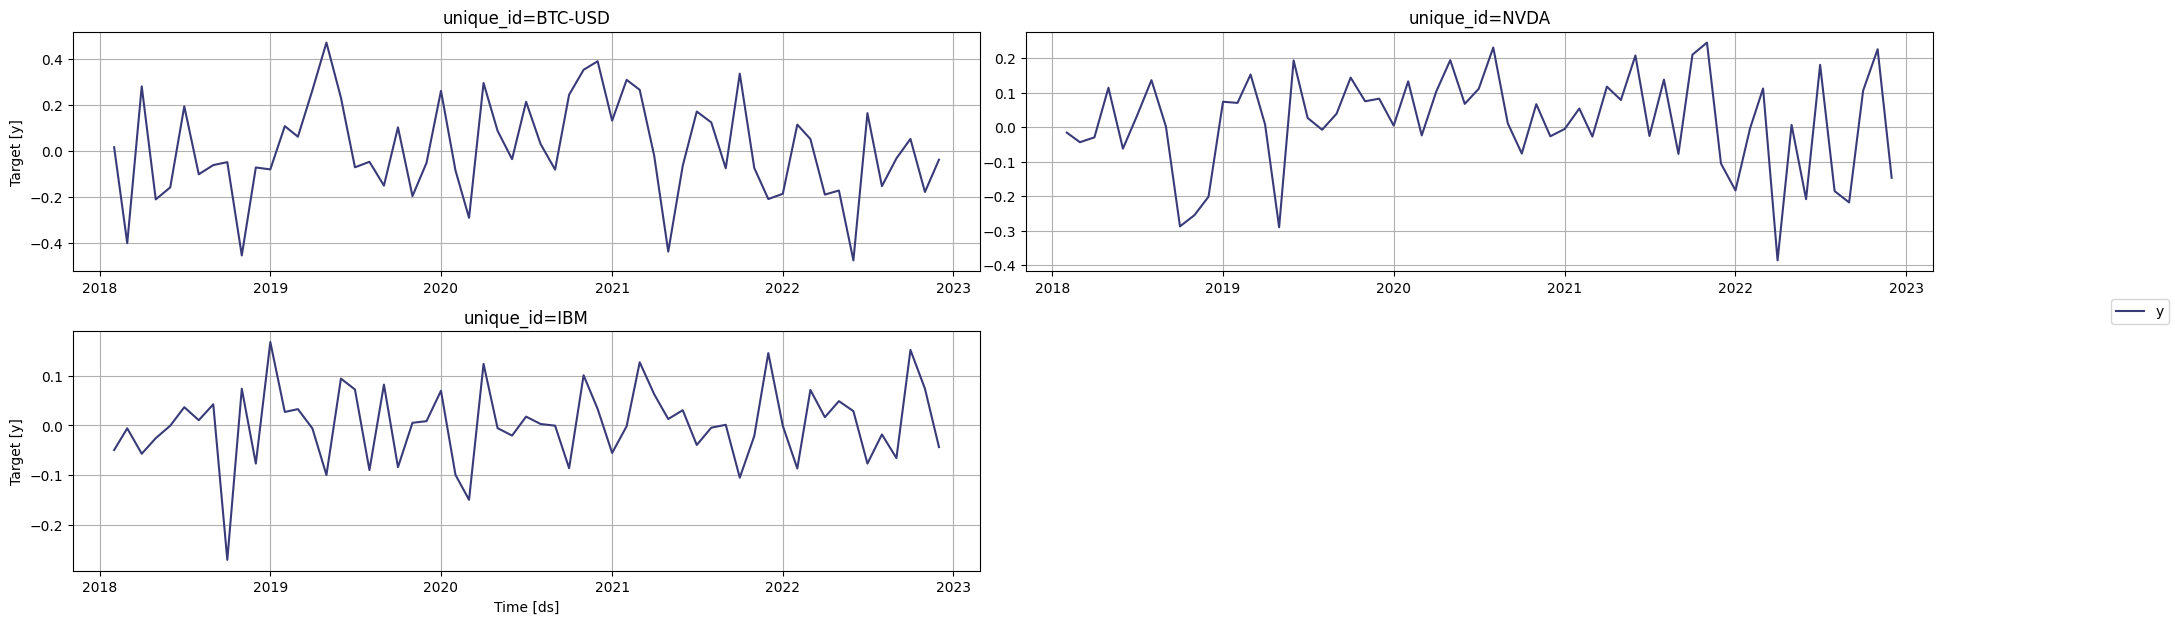

In [8]:
StatsForecast.plot(returns)

In [9]:
models = [ARCH(1), ARCH(2), GARCH(1,1), GARCH(1,2), GARCH(2,2), GARCH(2,1), AutoARIMA(), Naive()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)

In [10]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [11]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()


,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
0,BTC-USD,2022-01-01,2021-12-01,-0.185061,0.352319,0.356142,0.352912,0.356141,0.356143,0.356127,0.0,-0.207865
1,BTC-USD,2022-02-01,2021-12-01,0.115464,-0.132689,-0.134129,-0.132913,-0.134129,-0.134129,-0.134124,0.0,-0.207865
2,BTC-USD,2022-03-01,2021-12-01,0.052878,-0.114560,-0.115803,-0.114753,-0.115803,-0.115803,-0.115798,0.0,-0.207865
3,BTC-USD,2022-04-01,2022-03-01,-0.188507,0.345795,0.349285,0.346277,0.349251,0.349314,0.349291,0.0,0.052878
4,BTC-USD,2022-05-01,2022-03-01,-0.170830,-0.130232,-0.131547,-0.130414,-0.131534,-0.131558,-0.131549,0.0,0.052878


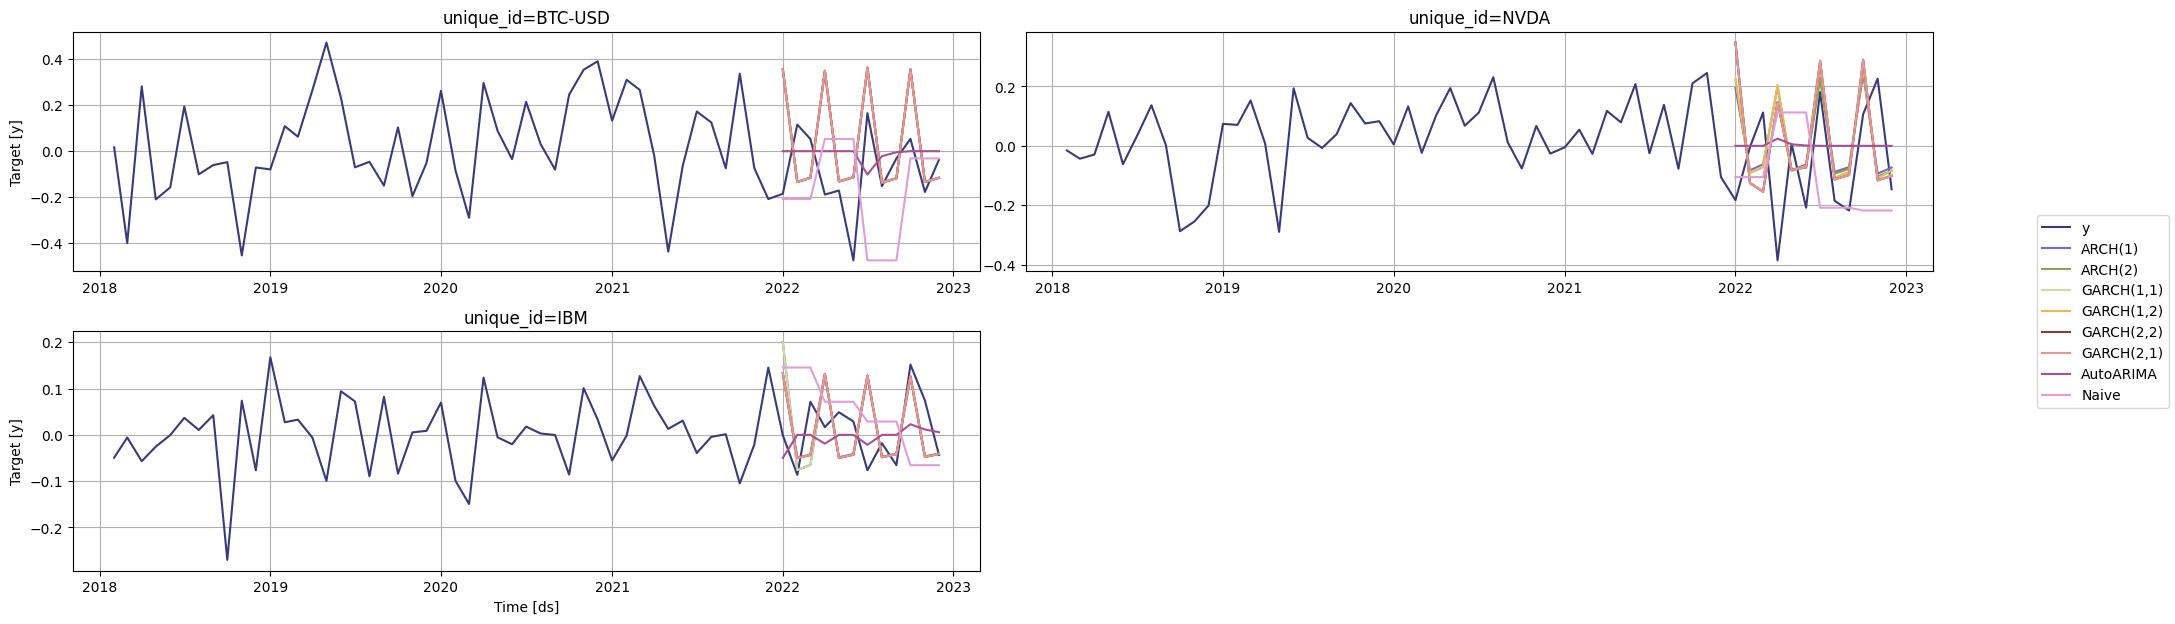

In [12]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [13]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
unique_id,,,,,,,,
BTC-USD,0.217303,0.218456,0.217498,0.218457,0.218454,0.218454,0.156474,0.270008
IBM,0.086219,0.080901,0.086659,0.081555,0.081554,0.081556,0.058307,0.099794
NVDA,0.189460,0.207871,0.199004,0.196168,0.211926,0.211928,0.165312,0.215289
